In [186]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests

from time import sleep

from collections import Counter
from matplotlib.gridspec import GridSpec

from sklearn import linear_model
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Opciones globales

In [187]:
# global settings for pandas.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('mode.chained_assignment', None)
pd.options.display.float_format = '{:.2f}'.format

# global settings for seaborn.
# sns.set_theme(style="whitegrid")
plt.style.use('seaborn')

Funciones globales

In [218]:
def describe_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un DataFrame {df}, devuelve otro DataFrame con datos descriptivos
    según las medidas especificadas en el diccionario {measures}.
    """
    measures = {
        'Cardinality': df.nunique(), 
        'Null': df.shape[0] - df.count(), 
        '% Null': round((df.shape[0] - df.count()) / df.shape[0] * 100, 3),
        'Non-Null': df.count(), 
        '% Non-Null': round(df.count() / df.shape[0] * 100, 3), 
        'Types': df.dtypes,
        'Size (mb)': df.memory_usage() / 1000000
    }    
    return pd.DataFrame(index=df.columns, data=measures)

def correlation_df(df):
    plt.figure(figsize=(16, 6))
    ax = sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
def fill_na_by(row, by_field, filter_field, lower_map, upper_map):
    """
    Permite rellenar con np.nan a un campo numérico del DataFrame en función de un intervalo definido por series.
    """
    
    if np.isnan(row[filter_field]):
        return np.nan
    
    lower_threshold = lower_map.loc[row[by_field]]
    upper_threshold = upper_map.loc[row[by_field]]
    
    return row[filter_field] if row[filter_field] >= lower_threshold and row[filter_field] <= upper_threshold else np.nan

def entrenar_plotear(x_original, y_original, alpha):
    x_original = x_original.to_numpy()
    y_original = y_original.to_numpy()
    # Split
    xo_train,xo_val,yo_train,yo_val = train_test_split(x_original,y_original,test_size=0.30,random_state=25)
    # print(xo_train.shape,xo_val.shape,yo_train.shape,yo_val.shape)
    # Pipeslines
    pipline_lr_std = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',LinearRegression())
    ])
    pipline_lr_SIN_std = Pipeline([
        ('modelo',LinearRegression())
    ])
    pipline_Enet_std_1 = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',ElasticNet(l1_ratio=1,alpha=alpha,max_iter=10000))
    ])
    pipline_Enet_std_05 = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000))
    ])
    pipline_Enet_std_0 = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',ElasticNet(l1_ratio=0,alpha=alpha,max_iter=10000))
    ])
    pipelines = [pipline_lr_std,pipline_lr_SIN_std,pipline_Enet_std_1,pipline_Enet_std_05,pipline_Enet_std_0]
    names = ['pipline_lr_std','pipline_lr_SIN_std','pipline_Enet_std_1','pipline_Enet_std_05','pipline_Enet_std_0']
    # Ploteo
    plt.figure(figsize=(15,10))
    k=3
    plt.subplots_adjust(bottom=1.5*k,top=2*k)
    for s,p in enumerate(pipelines):
        # print(s)
        # Entrenamiento
        p.fit(xo_train,yo_train)
        y_pred = p.predict(xo_val)
        # Resultados
        y_r2_score = r2_score(yo_val,y_pred)
        rmae = mean_squared_error(yo_val,y_pred)**0.5
        # Conf ploteo
        plt.subplot(3,2,s+1)
        plt.plot(yo_val,yo_val,'bo')
        plt.plot(yo_val,y_pred,'ro',alpha=0.25)
        plt.title('{0} R2 Score: {1} RMAE: {2}'.format(names[s],y_r2_score.round(3),rmae.round(3)))
        #plt.axis([yo_val.min()*1.1,yo_val.max()*1.1,yo_val.min()*1.1,yo_val.max()*1.1])        
    plt.show()

Datos originales

In [189]:
o_data = pd.read_csv(filepath_or_buffer='df_exploratory.csv')

### Revisión de observaciones por property_type

In [190]:
describe_df(o_data)

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,4,0,0.00,83505,100.00,object,0.67
state_name,28,0,0.00,83505,100.00,object,0.67
place_name,908,0,0.00,83505,100.00,object,0.67
lat,32788,38,0.05,83467,99.95,float64,0.67
lon,32780,38,0.05,83467,99.95,float64,0.67
price_aprox_usd,8460,0,0.00,83505,100.00,float64,0.67
surface_total_in_m2,929,3992,4.78,79513,95.22,float64,0.67
surface_covered_in_m2,565,2472,2.96,81033,97.04,float64,0.67
price_usd_per_m2,26228,0,0.00,83505,100.00,float64,0.67
rooms,9,20965,25.11,62540,74.89,float64,0.67


#### STORE

<AxesSubplot:>

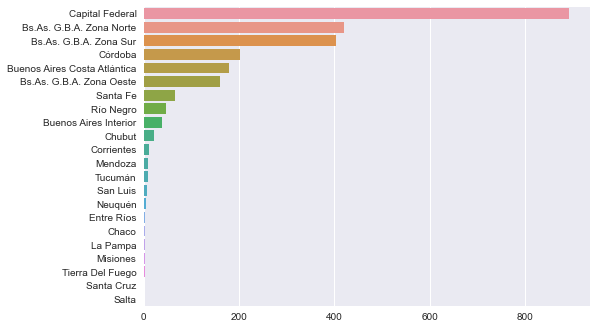

In [191]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'store']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'store']['state_name'].value_counts().values, 
    orient='h'
)

In [192]:
describe_df(o_data.loc[o_data['property_type'] == 'store'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,2488,100.00,object,0.02
state_name,22,0,0.00,2488,100.00,object,0.02
place_name,253,0,0.00,2488,100.00,object,0.02
lat,1362,2,0.08,2486,99.92,float64,0.02
lon,1361,2,0.08,2486,99.92,float64,0.02
price_aprox_usd,460,0,0.00,2488,100.00,float64,0.02
surface_total_in_m2,420,129,5.18,2359,94.81,float64,0.02
surface_covered_in_m2,392,152,6.11,2336,93.89,float64,0.02
price_usd_per_m2,1532,0,0.00,2488,100.00,float64,0.02
rooms,6,2184,87.78,304,12.22,float64,0.02


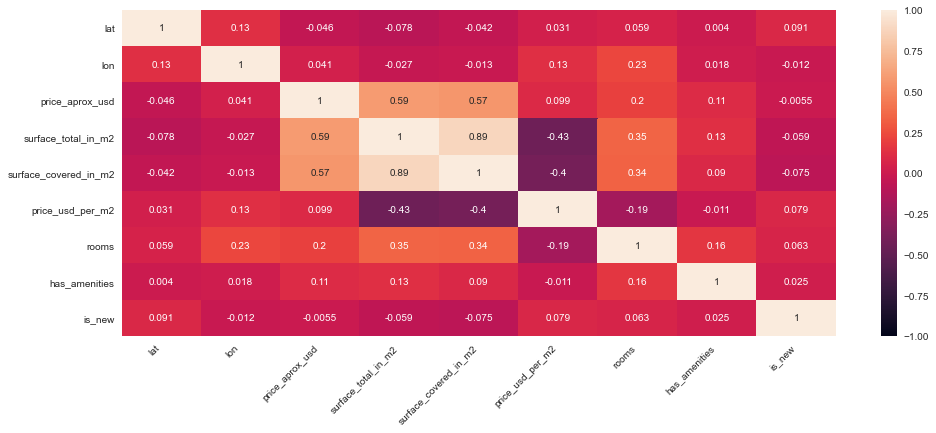

In [193]:
correlation_df(o_data.loc[o_data['property_type'] == 'store'])

#### APARTMENT

In [194]:
describe_df(o_data.loc[o_data['property_type'] == 'apartment'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,49811,100.00,object,0.40
state_name,25,0,0.00,49811,100.00,object,0.40
place_name,434,0,0.00,49811,100.00,object,0.40
lat,18032,6,0.01,49805,99.99,float64,0.40
lon,18010,6,0.01,49805,99.99,float64,0.40
price_aprox_usd,7918,0,0.00,49811,100.00,float64,0.40
surface_total_in_m2,220,1811,3.64,48000,96.36,float64,0.40
surface_covered_in_m2,145,1390,2.79,48421,97.21,float64,0.40
price_usd_per_m2,17564,0,0.00,49811,100.00,float64,0.40
rooms,6,7462,14.98,42349,85.02,float64,0.40


<AxesSubplot:>

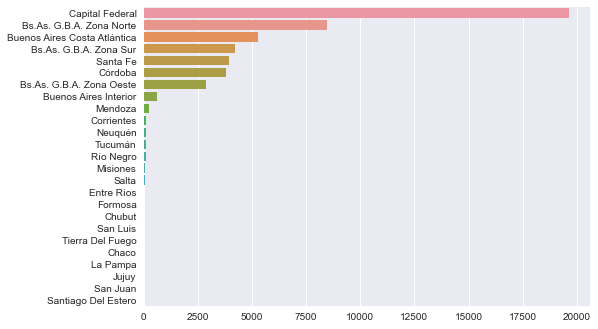

In [195]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'apartment']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'apartment']['state_name'].value_counts().values, 
    orient='h'
)

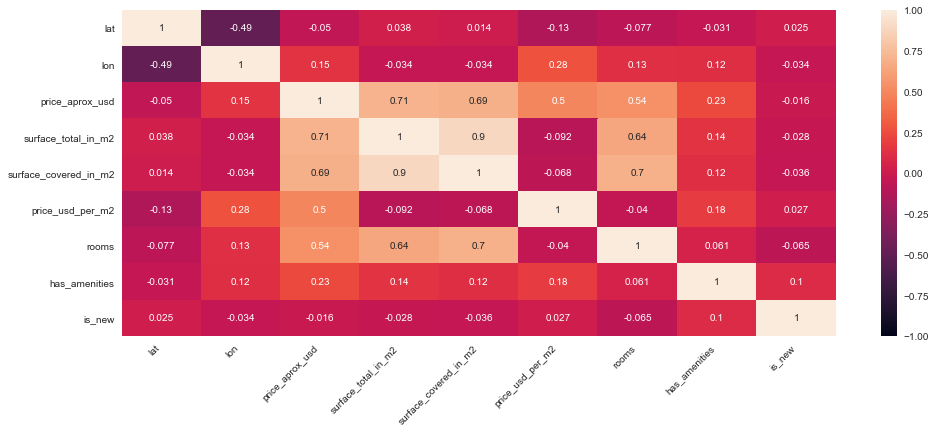

In [196]:
correlation_df(o_data.loc[o_data['property_type'] == 'apartment'])

#### PH

In [197]:
describe_df(o_data.loc[o_data['property_type'] == 'PH'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,4265,100.00,object,0.03
state_name,15,0,0.00,4265,100.00,object,0.03
place_name,249,0,0.00,4265,100.00,object,0.03
lat,2654,2,0.05,4263,99.95,float64,0.03
lon,2655,2,0.05,4263,99.95,float64,0.03
price_aprox_usd,398,0,0.00,4265,100.00,float64,0.03
surface_total_in_m2,215,169,3.96,4096,96.04,float64,0.03
surface_covered_in_m2,170,136,3.19,4129,96.81,float64,0.03
price_usd_per_m2,2180,0,0.00,4265,100.00,float64,0.03
rooms,7,614,14.40,3651,85.60,float64,0.03


<AxesSubplot:>

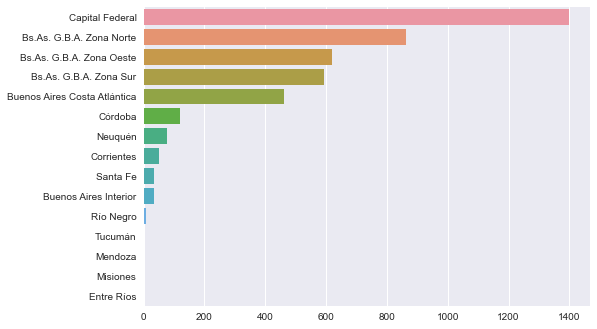

In [198]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'PH']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'PH']['state_name'].value_counts().values, 
    orient='h'
)

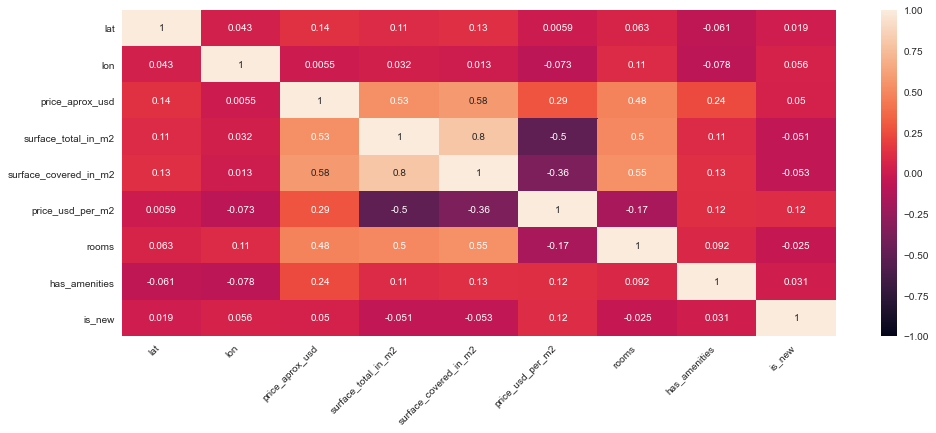

In [199]:
correlation_df(o_data.loc[o_data['property_type'] == 'PH'])

#### HOUSE

In [200]:
describe_df(o_data.loc[o_data['property_type'] == 'house'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,26941,100.00,object,0.22
state_name,27,0,0.00,26941,100.00,object,0.22
place_name,839,0,0.00,26941,100.00,object,0.22
lat,12085,28,0.10,26913,99.90,float64,0.22
lon,12076,28,0.10,26913,99.90,float64,0.22
price_aprox_usd,1048,0,0.00,26941,100.00,float64,0.22
surface_total_in_m2,830,1883,6.99,25058,93.01,float64,0.22
surface_covered_in_m2,487,794,2.95,26147,97.05,float64,0.22
price_usd_per_m2,10303,0,0.00,26941,100.00,float64,0.22
rooms,9,10705,39.73,16236,60.27,float64,0.22


<AxesSubplot:>

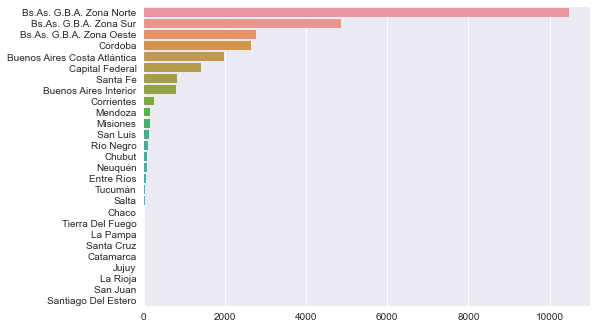

In [201]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'house']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'house']['state_name'].value_counts().values, 
    orient='h'
)

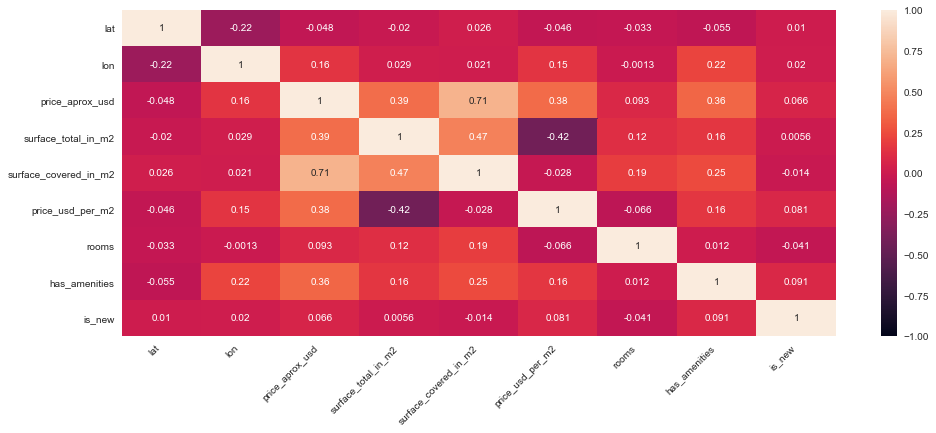

In [202]:
correlation_df(o_data.loc[o_data['property_type'] == 'house'])

### BUENOS AIRES

Se copian los datos originales y se filtra por las zonas correspondientes a Buenos Aires.

In [203]:
gba_data = o_data.copy()
gba_data = gba_data.loc[gba_data['state_name'].isin(['Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur'])]

,property_type,state_name,place_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,has_amenities,is_new
2,apartment,Buenos Aires Costa Atlántica,Centro,-38.00,-57.55,64000.00,35.00,35.00,1828.57,1.00,0.00,0.00
3,PH,Bs.As. G.B.A. Zona Norte,Munro,-34.53,-58.52,130000.00,106.00,78.00,1226.42,2.00,0.00,0.00
6,apartment,Bs.As. G.B.A. Zona Norte,Martínez,-34.49,-58.50,115000.00,39.00,36.00,2948.72,2.00,1.00,1.00
12,house,Bs.As. G.B.A. Zona Norte,Tigre,-34.43,-58.58,570000.00,270.00,270.00,2111.11,3.00,1.00,0.00
16,apartment,Bs.As. G.B.A. Zona Norte,Pilar,-34.45,-58.84,82000.00,48.00,42.00,1708.33,2.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
83389,apartment,Buenos Aires Costa Atlántica,Villa Gesell,-37.26,-56.97,120000.00,90.00,90.00,1333.33,5.00,0.00,0.00
83415,apartment,Bs.As. G.B.A. Zona Norte,Villa Ballester,-34.55,-58.56,175000.00,86.00,70.00,2034.88,3.00,1.00,0.00
83423,apartment,Bs.As. G.B.A. Zona Norte,Tigre,-34.42,-58.58,115000.00,50.00,50.00,2346.94,1.00,1.00,1.00
83436,apartment,Buenos Aires Costa Atlántica,Punta Iglesia,-38.00,-57.54,80523.00,37.00,37.00,2176.30,3.00,1.00,0.00


Opcional: filtrar outliers

In [204]:
# q1 = gba_data.groupby('property_type')['price_aprox_usd'].quantile(q=0.25)
# q3 = gba_data.groupby('property_type')['price_aprox_usd'].quantile(q=0.75)
# iqr = q3 - q1
# # la serie con el límite superior es estrictamente definida por el IQR.
# price_upper = q3 + 1.5 * iqr
# # la serie con el límite inferior se define en función de valores lógicos, debido a que el IQR incluye negativos.
# price_lower = pd.Series({'PH': 20000, 'apartment': 20000, 'house': 20000, 'store': 20000})

# gba_data['price_aprox_usd'] = gba_data.apply(fill_na_by, args=['property_type', 'price_aprox_usd', price_lower, price_upper], axis=1)

Visualizar cuartiles.

<AxesSubplot:xlabel='property_type', ylabel='price_aprox_usd'>

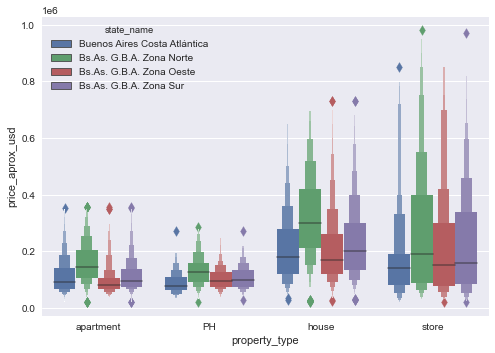

In [205]:
sns.boxenplot(y='price_aprox_usd',  x='property_type', hue='state_name', data=gba_data, orient='v')

Visualizar observaciones.

<AxesSubplot:xlabel='property_type', ylabel='price_aprox_usd'>

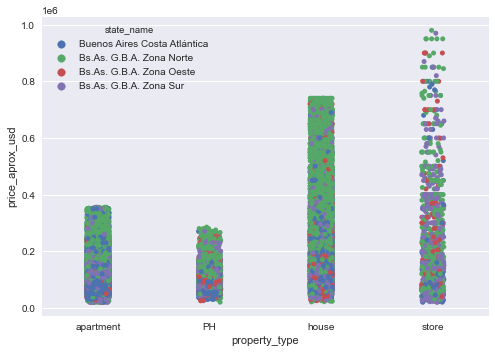

In [206]:
sns.stripplot(y='price_aprox_usd',  x='property_type', hue='state_name', data=gba_data, orient='v')

Para reducir la dimensionalidad del campo **place_name** se busca para cada par de coordenadas el municipio al cual corresponde. Esto se hace mediante llamados a la api pública https://datosgobar.github.io/georef-ar-api, para simplificar el código y aumentar la portabilidad se leen las respuestas desde el archivo JSON *responses.json*.

In [207]:
# concatenar coordenadas en un string separado por '&'.
gba_data['lat-lon'] = gba_data.apply(lambda x: f'{round(x.lat,2)}&{round(x.lon,2)}', axis=1)

# leer respuestas.
with open('responses.json') as f:
    responses = json.loads(f.read())
    
# armar diccionario de coordenadas y municipios.
lat_lon_map = dict()
for response in responses:
    if not response:
        continue
    for result in response['resultados']:
        lat_lon_map[f"{result['ubicacion']['lat']}&{result['ubicacion']['lon']}"] = result['ubicacion']

# nueva columna municipio a partir de las coordenadas.
gba_data['municipio'] = gba_data.apply(lambda x: lat_lon_map.get(x['lat-lon'], np.nan).get('municipio_nombre') if lat_lon_map.get(x['lat-lon']) is not None else np.nan, axis=1)

Cada *municipio* se transforma a variable continua mediante un proceso de pseudo-estandarización.  

In [263]:
# normalización del precio promedio del municipio (no recomendado).
# ppm_muni_std = (
#     gba_data.groupby(by=['state_name', 'property_type', 'municipio'])['price_usd_per_m2'].mean() 
#     - 
#     gba_data.groupby(by=['state_name', 'property_type'])['price_usd_per_m2'].mean()
# ) / gba_data.groupby(by=['state_name', 'property_type'])['price_usd_per_m2'].std()

# transformación logarítmica del precio promedio del municipio dividido el precio promedio de la zona (por property_type).
ppm_muni_std = np.log(gba_data.groupby(by=['state_name', 'property_type', 'municipio'])['price_usd_per_m2'].mean() / gba_data.groupby(by=['state_name', 'property_type'])['price_usd_per_m2'].mean())
ppm_muni_std_mean = ppm_muni_std.mean()

gba_data['ppm_municipio'] = gba_data.apply(
    lambda x: ppm_muni_std.loc[(x.state_name, x.property_type, x.municipio)] if x.municipio not in (None, np.nan) else ppm_muni_std_mean, 
    axis=1)

<AxesSubplot:xlabel='ppm_municipio'>

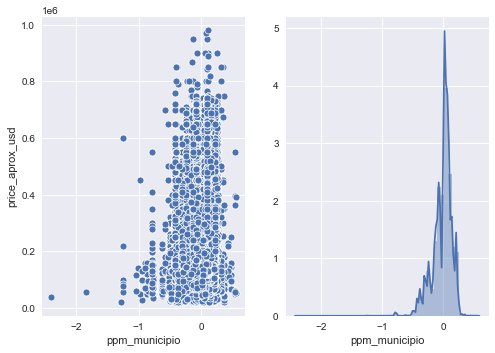

In [280]:
f, (ax0, ax1) = plt.subplots(1, 2)
sns.scatterplot(x='ppm_municipio', y='price_aprox_usd', data=gba_data, ax=ax0)
sns.distplot(gba_data['ppm_municipio'], ax=ax1)

In [266]:
# transformación logarítmica del precio promedio de la zona dividido el precio promedio del tipo de propiedad.
ppm_zone_std = np.log(gba_data.groupby(by=['property_type', 'state_name'])['price_usd_per_m2'].mean() / gba_data.groupby(by=['property_type'])['price_usd_per_m2'].mean())

ppm_zone_std_mean = ppm_zone_std.mean()

gba_data['ppm_zona'] = gba_data.apply(lambda x: ppm_zone_std.loc[(x.property_type, x.state_name)] if x.state_name not in (None, np.nan) else ppm_zone_std_mean, axis=1)

<AxesSubplot:xlabel='ppm_zona'>

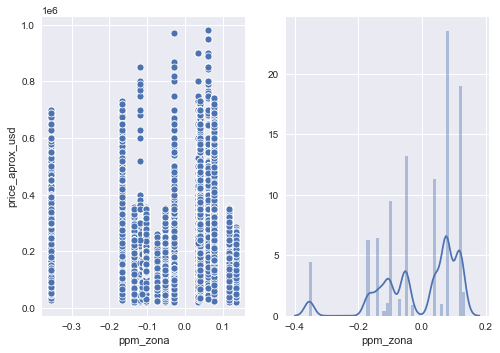

In [281]:
f, (ax0, ax1) = plt.subplots(1, 2)
sns.scatterplot(x='ppm_zona', y='price_aprox_usd', data=gba_data, ax=ax0)
sns.distplot(gba_data['ppm_zona'], ax=ax1)

Correlación entre las nuevas *features* agregadas.

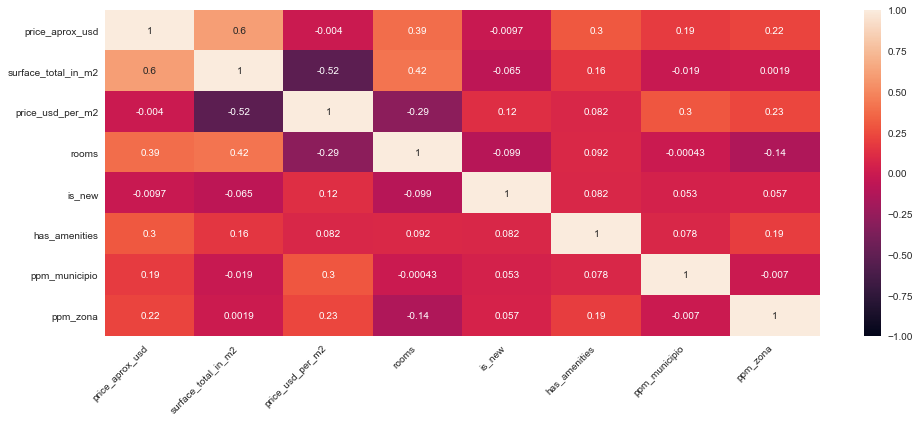

In [284]:
correlation_df(gba_data[['price_aprox_usd', 'surface_total_in_m2', 'price_usd_per_m2', 'rooms', 'is_new', 'has_amenities', 'ppm_municipio', 'ppm_zona']])

#### Escenario 01

- Sin nulos

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138924730673092.42, tolerance: 50987286619.98416
  positive)


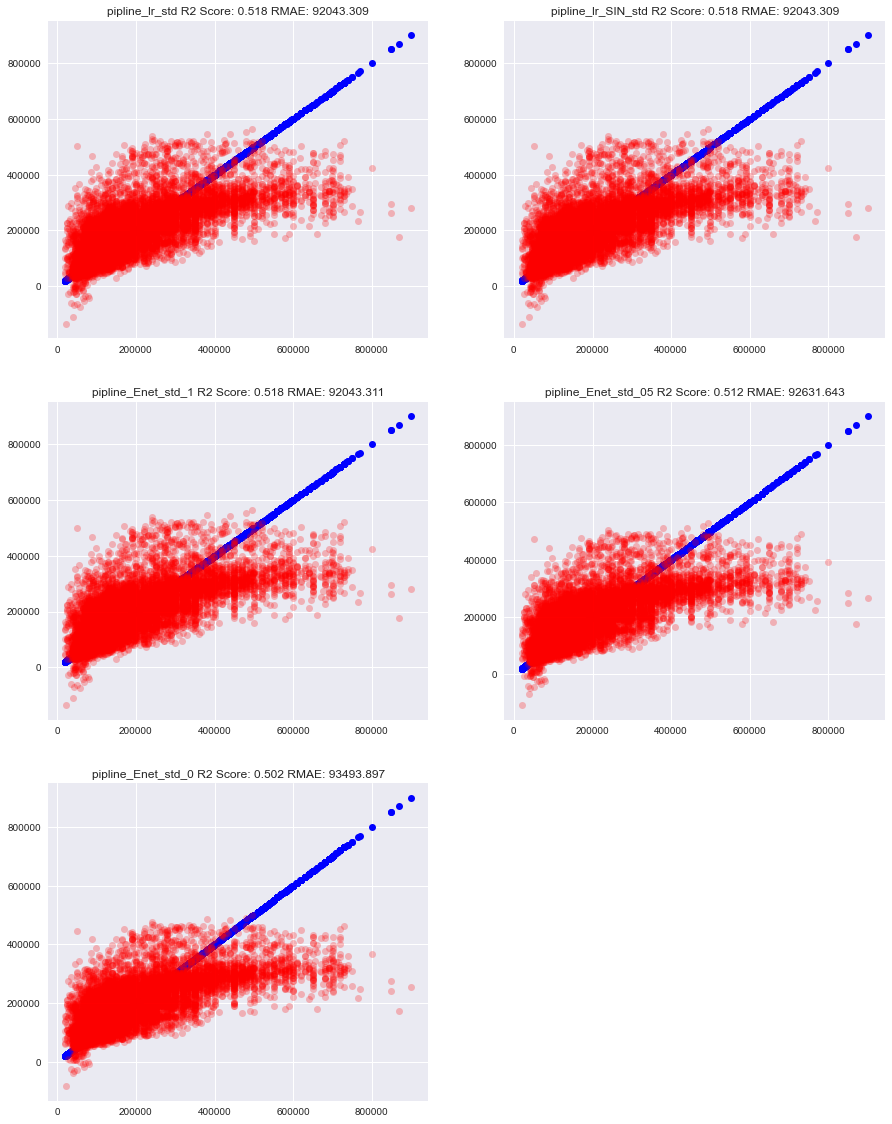

In [269]:
gba_eval_df = pd.get_dummies(data=gba_data, columns=['property_type'], drop_first=False)
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 2 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()
gba_eval_df.columns
features = ['property_type_apartment', 'property_type_house', 'property_type_store', 
            'ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

label = ['price_aprox_usd']

entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.25
)

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1210950011054.74, tolerance: 357115528.2924999
  positive)


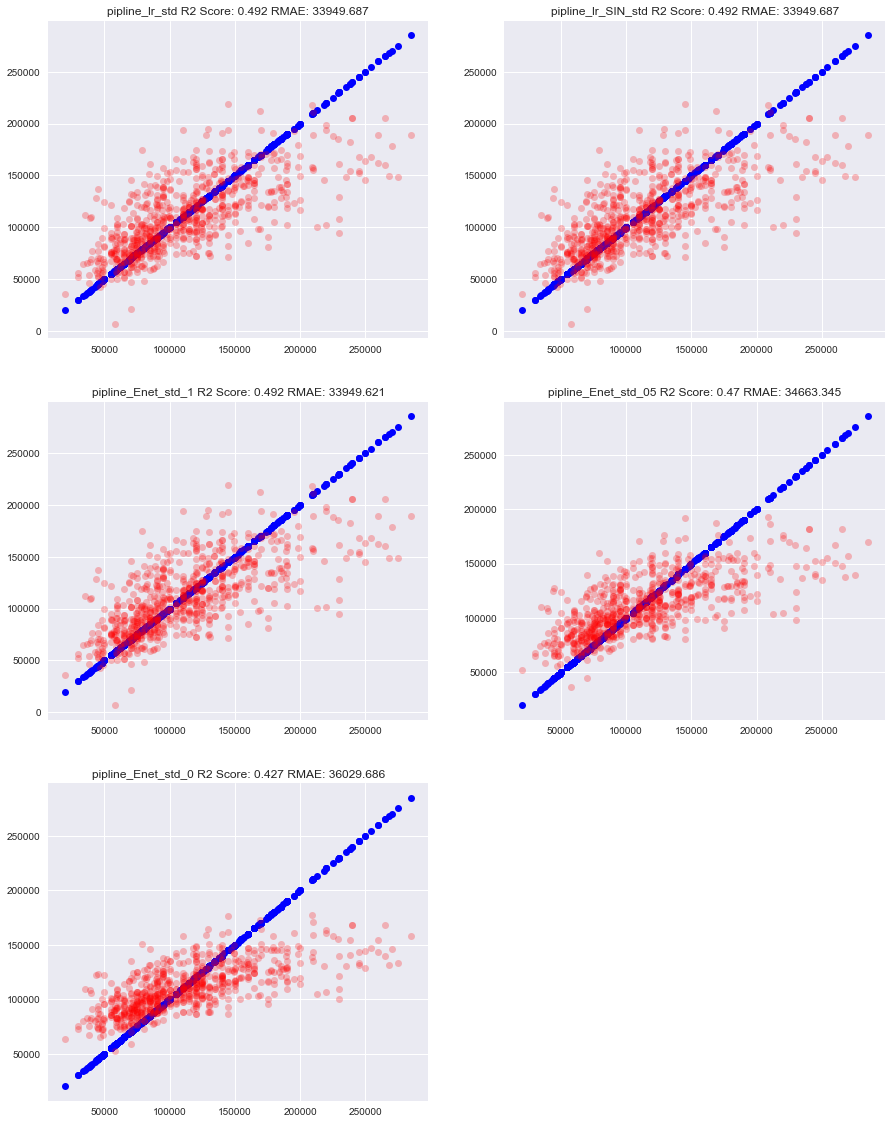

In [270]:
gba_eval_df = gba_data.copy().loc[gba_data['property_type'] == 'PH']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 4 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()
gba_eval_df.columns

features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

label = ['price_aprox_usd']

entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8620705133713.883, tolerance: 2341716789.1190968
  positive)


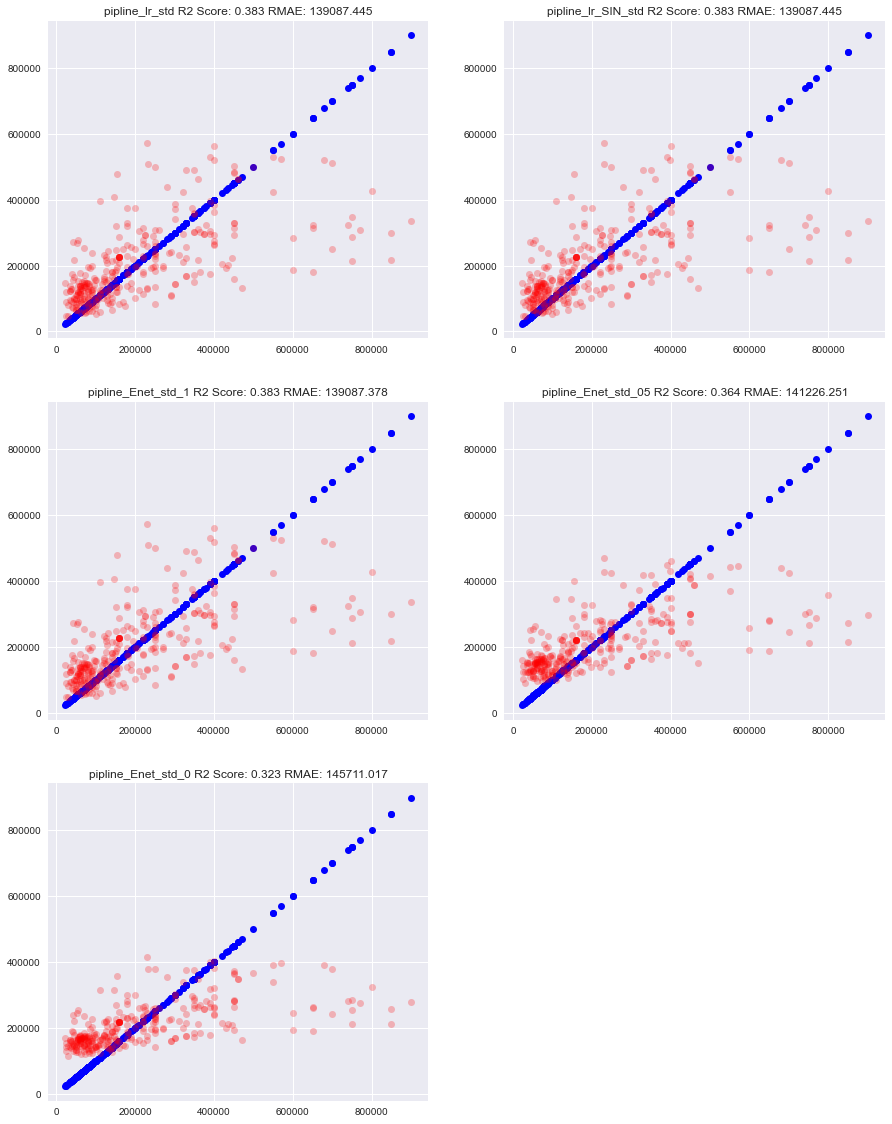

In [271]:
gba_eval_df = gba_data.copy().loc[gba_data['property_type'] == 'store']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 4 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()
gba_eval_df.columns
features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

label = ['price_aprox_usd']

entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109496957690785.25, tolerance: 27785009786.275295
  positive)


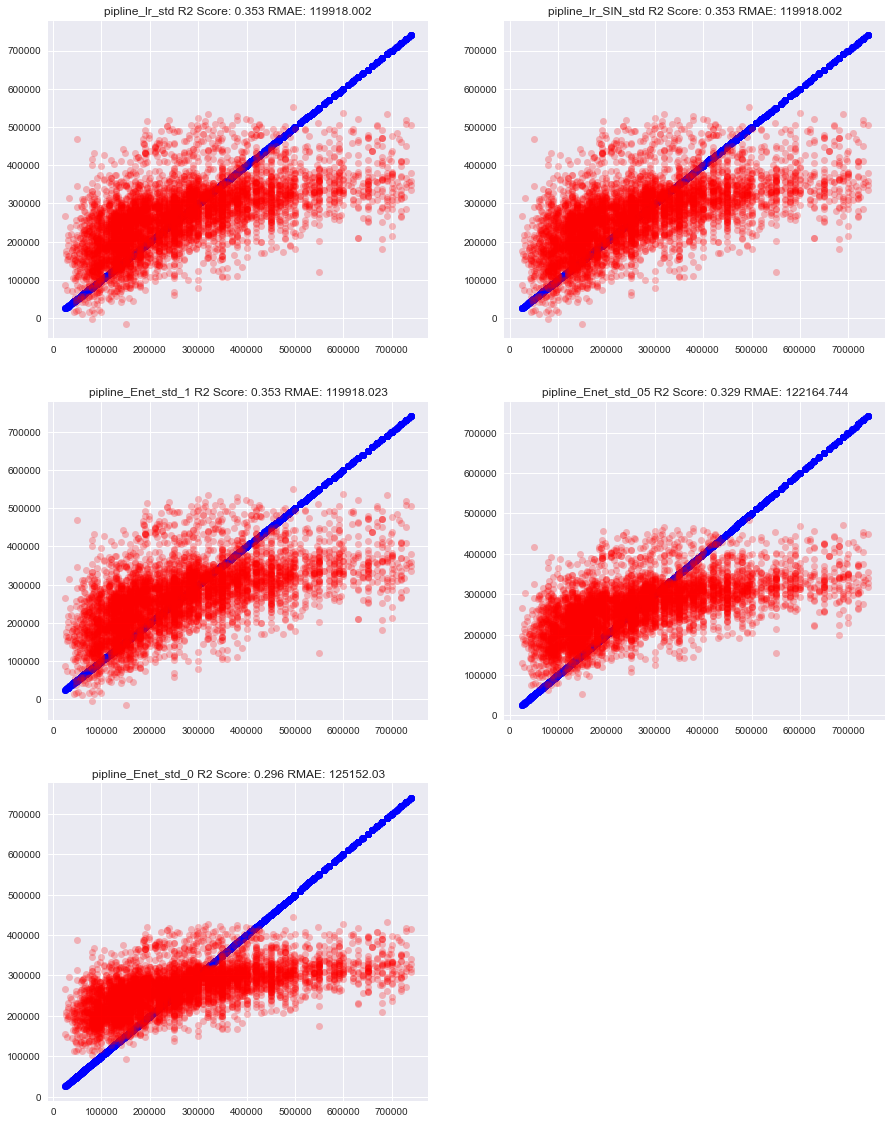

In [272]:
gba_eval_df = gba_data.copy().loc[gba_data['property_type'] == 'house']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 4 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()
gba_eval_df.columns
features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

label = ['price_aprox_usd']

entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16872705708856.484, tolerance: 6009462999.703665
  positive)


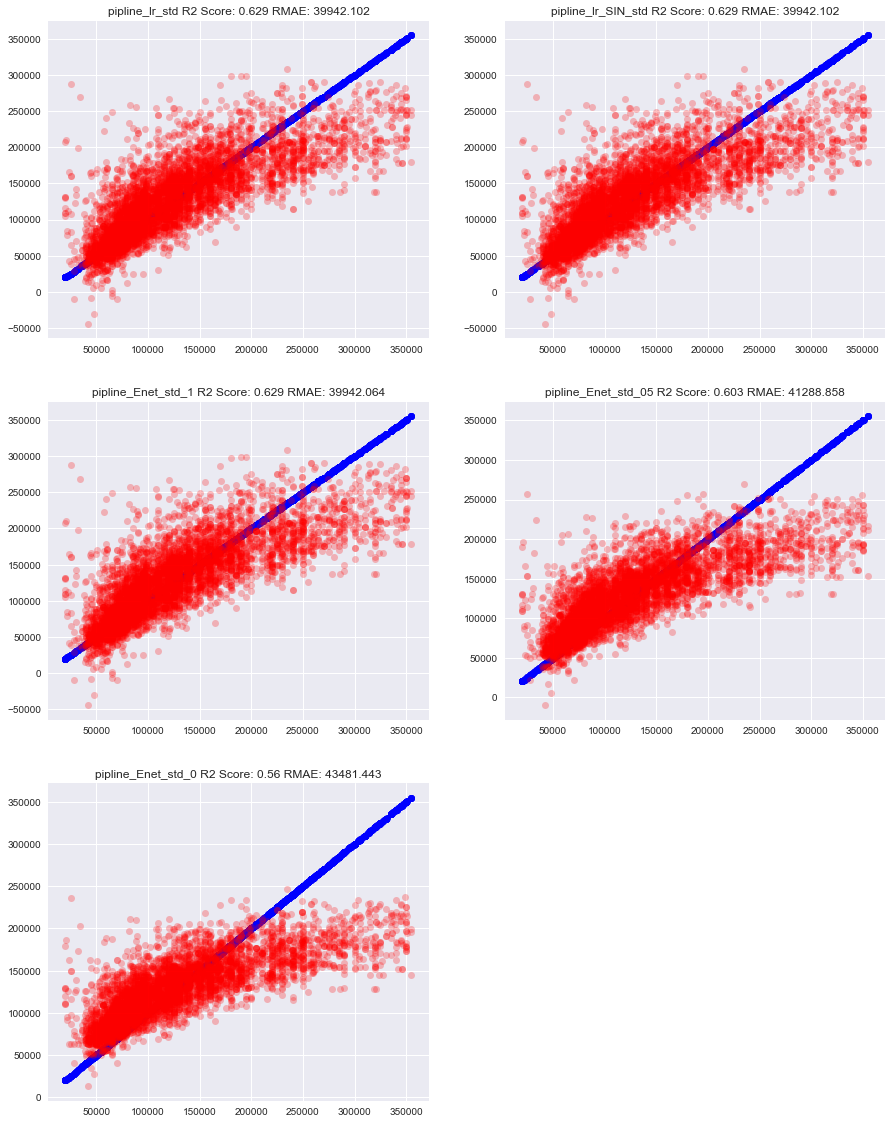

In [273]:
gba_eval_df = gba_data.loc[gba_data['property_type'] == 'apartment']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 2 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()
gba_eval_df.columns
features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities']

label = ['price_aprox_usd']

entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

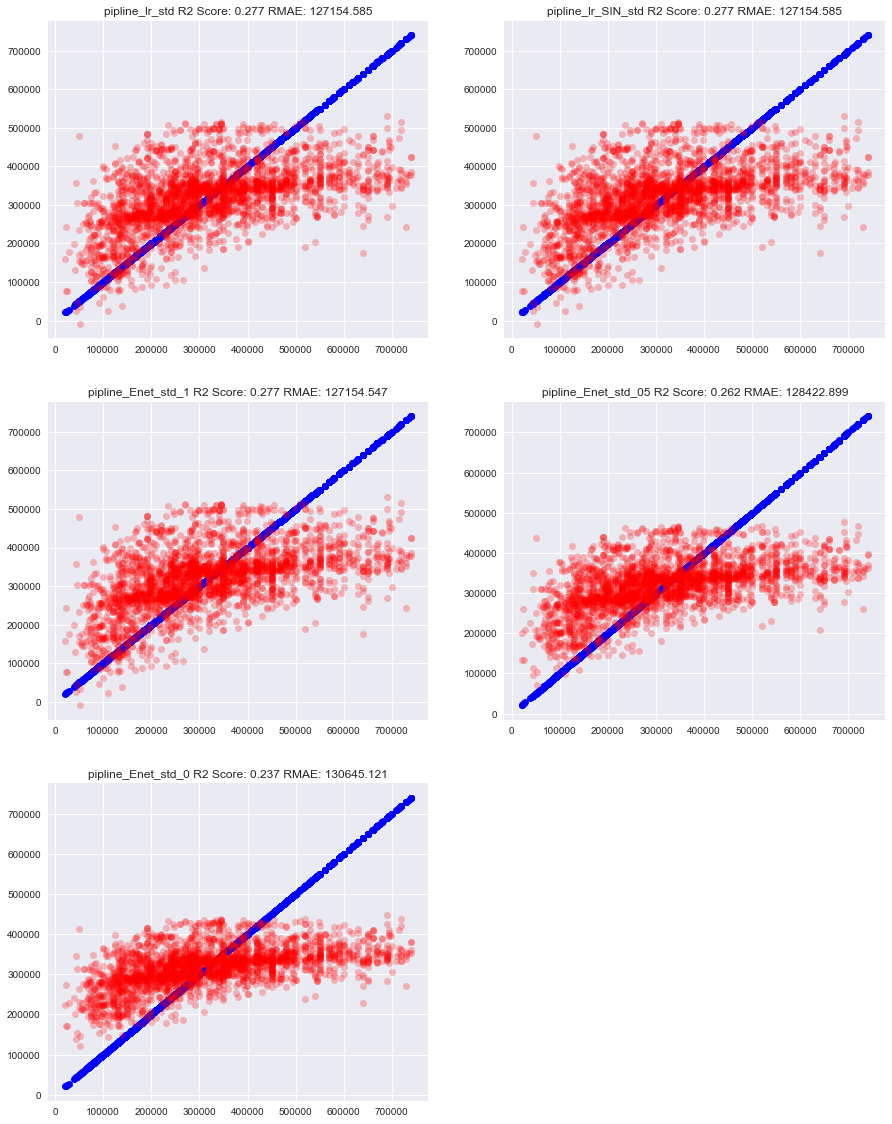

In [279]:
gba_eval_df = gba_data.copy().loc[(gba_data['property_type'] == 'house') & (gba_data['state_name'] == 'Bs.As. G.B.A. Zona Norte')]
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 3 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()
gba_eval_df.columns
features = ['ppm_municipio', 'surface_total_in_m2', 'rooms', 'is_new', 'has_amenities']

label = ['price_aprox_usd']

entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

In [274]:
gba_data.state_name

2        Buenos Aires Costa Atlántica
3            Bs.As. G.B.A. Zona Norte
6            Bs.As. G.B.A. Zona Norte
9            Bs.As. G.B.A. Zona Norte
11           Bs.As. G.B.A. Zona Norte
                     ...             
83449          Bs.As. G.B.A. Zona Sur
83450        Bs.As. G.B.A. Zona Norte
83451        Bs.As. G.B.A. Zona Norte
83501        Bs.As. G.B.A. Zona Norte
83503    Buenos Aires Costa Atlántica
Name: state_name, Length: 44607, dtype: object

In [215]:
gba_count = gba_data.groupby(by=['property_type', 'municipio'])['state_name'].count()
gba_count = gba_count.loc[gba_count <= 20]
gba_count.index.values

array([('PH', 'Berazategui'), ('PH', 'Berisso'), ('PH', 'Bolívar'),
       ('PH', 'Daireaux'), ('PH', 'Ensenada'), ('PH', 'Escobar'),
       ('PH', 'Esteban Echeverría'), ('PH', 'Ezeiza'),
       ('PH', 'Florencio Varela'), ('PH', 'General Alvarado'),
       ('PH', 'General Alvear'), ('PH', 'General Rodríguez'),
       ('PH', 'Hurlingham'), ('PH', 'José C. Paz'), ('PH', 'La Costa'),
       ('PH', 'Malvinas Argentinas'), ('PH', 'Mar Chiquita'),
       ('PH', 'Marcos Paz'), ('PH', 'Merlo'), ('PH', 'Monte Hermoso'),
       ('PH', 'Moreno'), ('PH', 'Necochea'), ('PH', 'Pilar'),
       ('PH', 'Pinamar'), ('PH', 'Villa Gesell'),
       ('apartment', 'Berisso'), ('apartment', 'Bolívar'),
       ('apartment', 'Cañuelas'), ('apartment', 'Ensenada'),
       ('apartment', 'Florencio Varela'),
       ('apartment', 'General Rodríguez'), ('apartment', 'Hurlingham'),
       ('apartment', 'José C. Paz'), ('apartment', 'Mar Chiquita'),
       ('apartment', 'Marcos Paz'), ('apartment', 'Miramar'),
     